## Bachelor Thesis - Informatik

### Variante 1 :
### Klassisches Neuronales Netz mit Fully Connected (Dense) Layern

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Ein Datensatz der bei Kaggle zur Verfügung steht

###### ☑️ Ein Datensatz der aus dem Ninapro DB5 Datensatz abgeleitet wurde

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">

#### ▶️ Installation notwendiger Python-Bibliotheken

In [ ]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install tensorflow

#### ▶️ Importieren notwendiger Python-Bibliotheken

In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

#### ▶️ Alternative 1: Einlesen der eigenen Roh-Daten aus dem Quellordner

In [3]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene/P1L' + label + '.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene/P2L' + label + '.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene/P3L' + label + '.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene/P4L' + label + '.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)

all_data = pd.concat([proband1, proband2, proband3, proband4])

#### ▶️ Alternative 2: Einlesen des Datensatz EMG-4 von Kaggle aus dem Quellordner

[https://www.kaggle.com/code/akshita72/hand-gesture-recognition-from-emg-signals/input]

In [19]:
# Die Dateien im Ordner "Kaggle" enthalten Auszüge aus dem originalen Datensatz
# Dieser wird unverändert übernommen


# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema:
# Label 0 --> Stein
# Label 1 --> Schere
# Label 2 --> Papier
# Label 3 --> OK-Zeichen


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Version "short" --> Datensatz hat 8 Sensorwerte je Zeile   #
# Version "medium" --> Datensatz hat 16 Sensorwerte je Zeile #
# Version "long"   --> Datensatz hat 64 Sensorwerte je Zeile #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', ]:
    single_data.append(pd.read_csv('./Kaggle/' + label + '_long.csv', sep=',', header=None))    
    #single_data.append(pd.read_csv('./Kaggle/' + label + '_medium.csv', sep=';', header=None))        
    #single_data.append(pd.read_csv('./Kaggle/' + label + '_short.csv', sep=';', header=None))        
    

    # Für Version "short"
    #single_data[int(label)][8] = int(label)

    # Für Version "medium"
    #single_data[int(label)][16] = int(label)

    # Für Version "long"
    single_data[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)
all_data

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11673,-3.0,-1.0,-1.0,-1.0,-28.0,20.0,5.0,0.0,-5.0,0.0,...,-3.0,1.0,4.0,3.0,4.0,-51.0,-49.0,5.0,-9.0,3
11674,-13.0,-5.0,-4.0,-3.0,-4.0,-24.0,-10.0,-8.0,20.0,9.0,...,6.0,-3.0,-3.0,-3.0,-5.0,-4.0,-45.0,-12.0,-15.0,3
11675,-1.0,-3.0,-1.0,1.0,30.0,38.0,-1.0,36.0,-10.0,1.0,...,14.0,-8.0,-4.0,-4.0,-4.0,-21.0,-29.0,-5.0,0.0,3
11676,1.0,4.0,4.0,5.0,9.0,-10.0,4.0,1.0,-2.0,-1.0,...,-16.0,-3.0,0.0,-3.0,-5.0,-36.0,-90.0,3.0,5.0,3


#### ▶️ Alternative 3 : Einlesen von Daten aus dem Ninapro DB5 Datensatz<br>
****
📌 Dieses Feld ausführen bei Verwendung Ninapro-Daten !!

[Link zum Datensatz](https://ninapro.hevs.ch/instructions/DB5.html)

In [18]:
# Die Dateien im Ordner "Ninapro_DB5" enthalten Auszüge aus dem originalen Datensatz
# Aus den Matlab-Files wurden die 8 Sensorwerte und die zugehörigen Labels entnommen
# Es wurden nur die "Subjects" 01 bis 06 berücksichtigt

# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt

##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['1', '2', '3', '4', '5', '6']:
    single_data.append(pd.read_csv('./Ninapro_DB5/P' + label + '.csv', sep=';', header=None))    
    

##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)

#### ▶️ Daten normalisieren

In [35]:
##############################################################
# Datenskalierung mit Min-/Max Prinzip oder Z-Score          #
##############################################################  
#sc = MinMaxScaler()
#sc = StandardScaler()


##############################################################
# Normalisiere den Datensatz                                 #
##############################################################  
# Für Version "short" einkommentieren
#X = all_data.drop(8, axis=1).copy()

# Für Version "medium" einkommentieren
#X = all_data.drop(16, axis=1).copy()

# Für Version "long" einkommentieren
X = all_data.drop(64, axis=1).copy()


#X = sc.fit_transform(X)
X = np.array(X).astype('float32')
X = np.clip(X, -20, 20)

#X_validate = proband4.drop(64, axis=1).copy()
#X_validate = sc.fit_transform(X_validate)
#X_validate = np.array(X_validate).astype('float32')


##############################################################
# Labels extrahieren aus Datensatz                           #
##############################################################  
y = all_data[all_data.columns[-1]]
y = np.array(y).astype('int')

#y_validate = proband4[64]
#y_validate = np.array(y_validate).astype('int')


##############################################################
# Vektorformen ausgeben                                      #
##############################################################  
print(X.shape)
print(y.shape)

#print(X_validate.shape)
#print(y_validate.shape)


(6064, 64)
(6064,)



#### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [36]:

##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
num_classes = 4


##############################################################
# Einkommentieren für den Ninapro-Datensatz                  #
# Fixwert 7                                                  #
##############################################################
#num_classes = 7

##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
#print("X_val Vectorform:", X_validate.shape)
print("y_train Vectorform:", y_train.shape)
print("y_test Vectorform:", y_test.shape)
#print("y_val Vectorform:", y_validate.shape)
print()
print(X.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")


X_train Vectorform: (4244, 64)
X_test Vectorform: (1820, 64)
y_train Vectorform: (4244,)
y_test Vectorform: (1820,)

6064 Gesamtwerte
4244 Trainingswerte
1820 Testwerte


#### ▶️ Machine-Learning Modell erstellen

In [50]:
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##############################################################
# Hyperparameter                                             #
##############################################################

batch_size = 16
epochs = 40
initializer='glorot_uniform'


# Format der Eingabedaten festlegen
input_shape = (X.shape[1],)


# Modell schichtweise erstellen
model = keras.Sequential()
model.add(layers.InputLayer(input_shape, kernel_initializer=initializer))
#model.add(layers.Dense(128, activation='elu'))
#model.add(layers.Dense(64, activation='elu'))
model.add(layers.Dense(512, activation='elu'))
model.add(layers.Dense(num_classes,activation='softmax'))

# Modellparameter ausgeben
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,332 (138.02 KB)

 Trainable params: 35,332 (138.02 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')

# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    #validation_data=(X_validate, y_validate),
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3460 - loss: 2.3520 - val_accuracy: 0.5265 - val_loss: 1.2734 - learning_rate: 0.0010
Epoch 2/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.9323 - val_accuracy: 0.5783 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 3/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7471 - loss: 0.6376 - val_accuracy: 0.6148 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 4/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7921 - loss: 0.5219 - val_accuracy: 0.6313 - val_loss: 0.9290 - learning_rate: 0.0010
Epoch 5/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8318 - loss: 0.3979 - val_accuracy: 0.6384 - val_loss: 0.9569 - learning_rate: 0.0010
Epoch 6/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8295 - loss: 0.4141 - val_accuracy: 0.6784 - val_loss: 0.9414 - learning_rate: 0.0010
Epoch 7/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8808 - loss: 0.3150 - 

### ▶️ Ausgabe der Kostenfunktion für Training und Validation

In [49]:
# Ausgeben der verfügbaren Metriken 
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


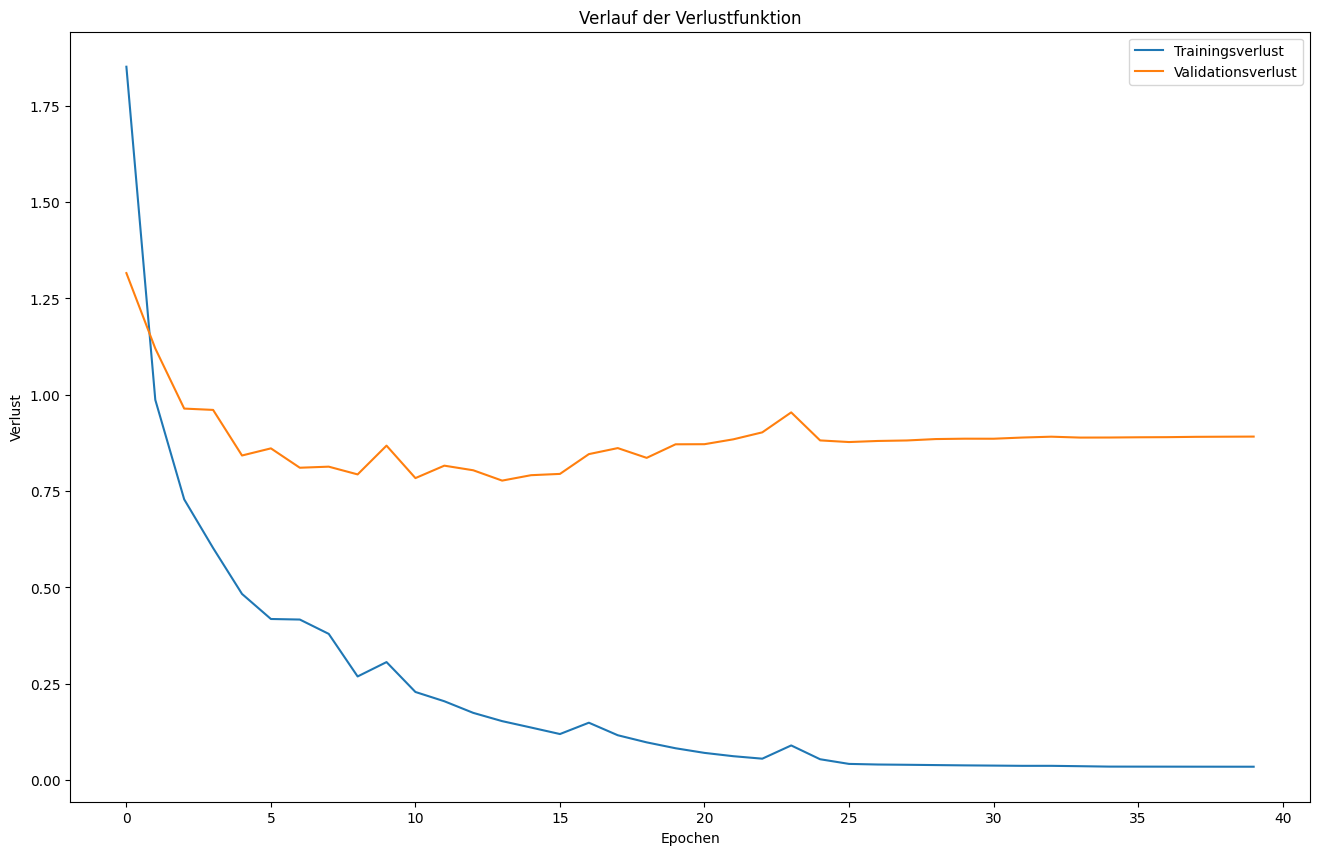

In [49]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

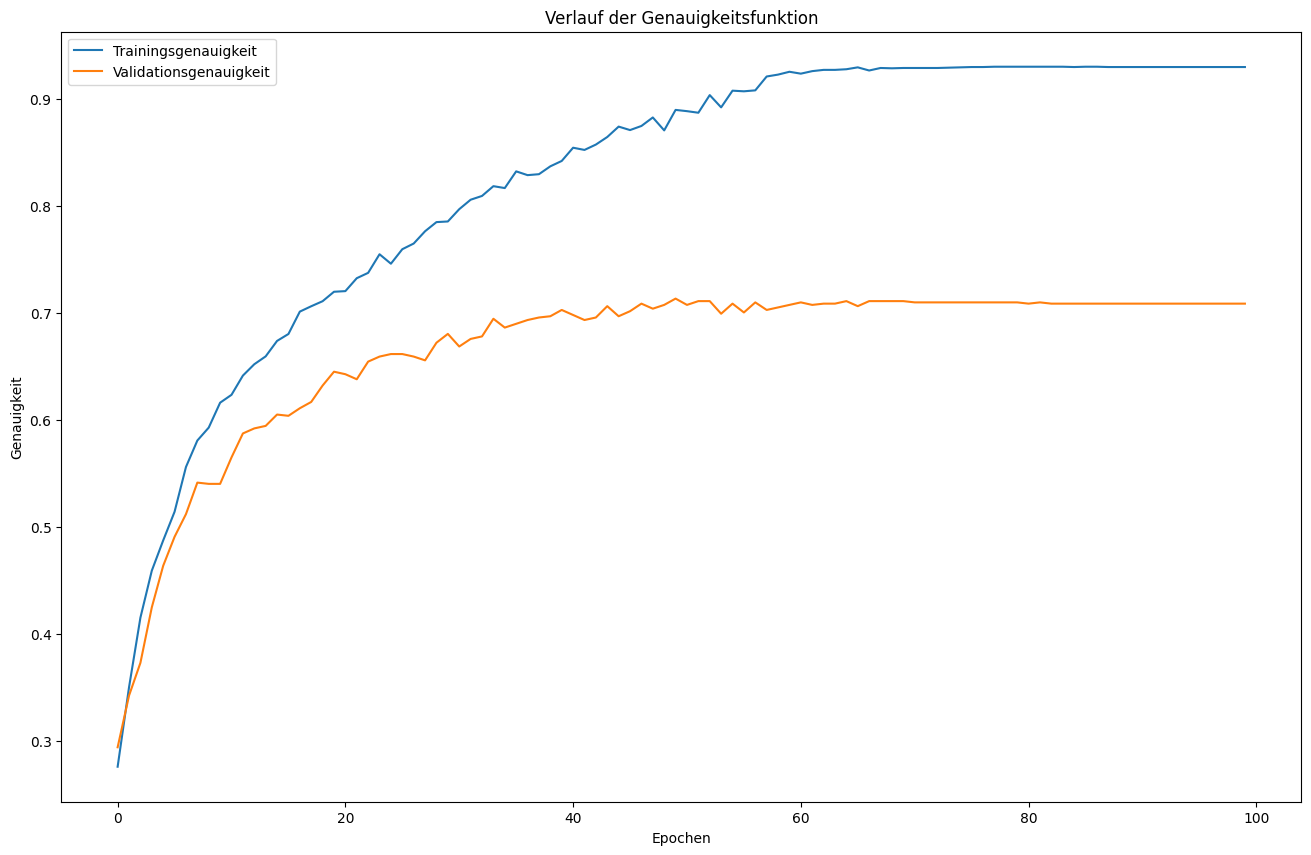

In [27]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Modell auf Testdaten anwenden und evaluieren

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7369990348815918
Test accuracy: 0.6884615421295166


In [29]:
y = model.predict(np.array(X))[1850]
#print(X[3212])
print("Es handelt sich um Geste : " + str(np.argmax(y)))


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Es handelt sich um Geste : 1


### ▶️ Metriken zur Beurteilung der Modellqualität 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


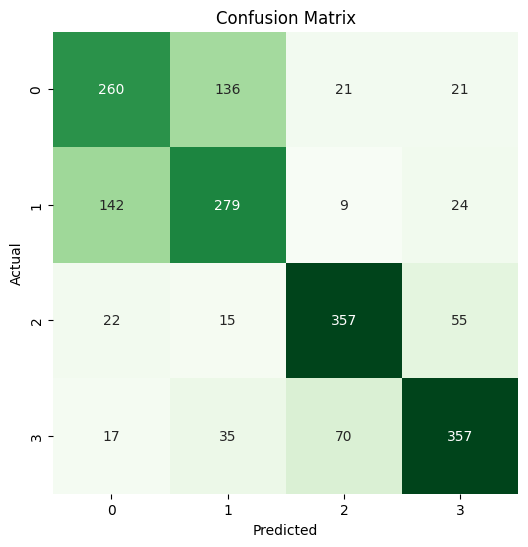

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       438
           1       0.60      0.61      0.61       454
           2       0.78      0.80      0.79       449
           3       0.78      0.75      0.76       479

    accuracy                           0.69      1820
   macro avg       0.69      0.69      0.69      1820
weighted avg       0.69      0.69      0.69      1820



In [30]:
y_true = np.array(y_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))